In [60]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from pathlib import Path
import zipfile
import matplotlib.pyplot as plt
import os

# Setup device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Import data and prepare datasets and dataloaders

In [9]:
# Extract zip file for first time
zip_path = Path("Bird dataset/archive.zip")
data_path = Path("Bird dataset/")
if zip_path.exists():
    print("Extract zip file")
    with zipfile.ZipFile(zip_path) as file:
        file.extractall(data_path)
    # Remove zip file
    Path.unlink(zip_path)
else:
    print("Already extracted")

Already extracted


In [11]:
# Create transformers to convert images into tensors
data_transformer = transforms.Compose([
    # Resize images to 150 x 150
    transforms.Resize(size=(150, 150)),
    # Augment data by flipping
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomVerticalFlip(),
    # Transform images into tensors and automatically scale them
    transforms.ToTensor()    
])

In [16]:
# Create paths to folders
train_dir = data_path.joinpath("train")
test_dir = data_path.joinpath("test")
val_dir = data_path.joinpath("valid")

# Create datasets
train_data = datasets.ImageFolder(root=train_dir, transform=data_transformer)
test_data = datasets.ImageFolder(root=test_dir, transform=data_transformer)
val_data = datasets.ImageFolder(root=val_dir, transform=data_transformer)

print(train_data)

Dataset ImageFolder
    Number of datapoints: 84635
    Root location: Bird dataset/train
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )


In [18]:
# Inspect classes
class_names = train_data.classes
print(class_names)
print(f"Number of classes: {len(class_names)}")

['ABBOTTS BABBLER', 'ABBOTTS BOOBY', 'ABYSSINIAN GROUND HORNBILL', 'AFRICAN CROWNED CRANE', 'AFRICAN EMERALD CUCKOO', 'AFRICAN FIREFINCH', 'AFRICAN OYSTER CATCHER', 'AFRICAN PIED HORNBILL', 'AFRICAN PYGMY GOOSE', 'ALBATROSS', 'ALBERTS TOWHEE', 'ALEXANDRINE PARAKEET', 'ALPINE CHOUGH', 'ALTAMIRA YELLOWTHROAT', 'AMERICAN AVOCET', 'AMERICAN BITTERN', 'AMERICAN COOT', 'AMERICAN DIPPER', 'AMERICAN FLAMINGO', 'AMERICAN GOLDFINCH', 'AMERICAN KESTREL', 'AMERICAN PIPIT', 'AMERICAN REDSTART', 'AMERICAN ROBIN', 'AMERICAN WIGEON', 'AMETHYST WOODSTAR', 'ANDEAN GOOSE', 'ANDEAN LAPWING', 'ANDEAN SISKIN', 'ANHINGA', 'ANIANIAU', 'ANNAS HUMMINGBIRD', 'ANTBIRD', 'ANTILLEAN EUPHONIA', 'APAPANE', 'APOSTLEBIRD', 'ARARIPE MANAKIN', 'ASHY STORM PETREL', 'ASHY THRUSHBIRD', 'ASIAN CRESTED IBIS', 'ASIAN DOLLARD BIRD', 'ASIAN GREEN BEE EATER', 'ASIAN OPENBILL STORK', 'AUCKLAND SHAQ', 'AUSTRAL CANASTERO', 'AUSTRALASIAN FIGBIRD', 'AVADAVAT', 'AZARAS SPINETAIL', 'AZURE BREASTED PITTA', 'AZURE JAY', 'AZURE TANAGER', '

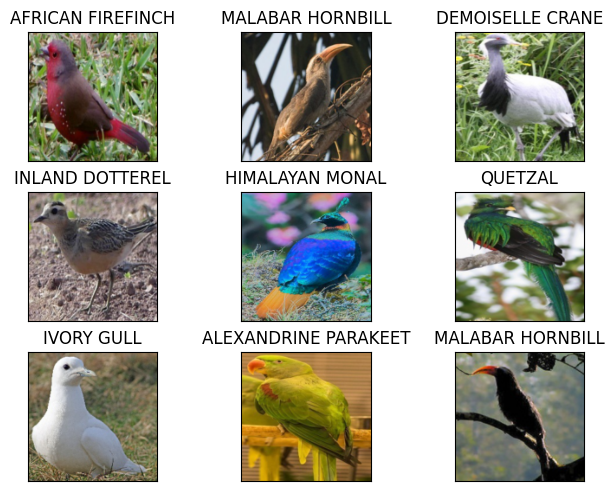

In [58]:
# Inspect 9 random images
import random
fig, ax = plt.subplots(3,3, layout="constrained")
ax = ax.flatten()
for i in range(9):
    rnd_pick = random.choice(train_data)
    img, label = rnd_pick[0], rnd_pick[1]
    ax[i].imshow(img.permute(1,2,0))
    ax[i].set_title(class_names[label])
    ax[i].set_xticklabels("")
    ax[i].set_yticklabels("")
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.show()

In [64]:
# Create dataloaders
train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=32,
    num_workers=os.cpu_count(),
    shuffle=True
)
test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=32,
    num_workers=os.cpu_count(),
    shuffle=False
)
val_dataloader = DataLoader(
    dataset=val_data,
    batch_size=32,
    num_workers=os.cpu_count(),
    shuffle=False
)

# Model 0 (Baseline)